In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import math

from utils import all_letters, n_letters
from utils import load_data, letter_to_tensor, line_to_tensor, category_from_output, random_choice

In [2]:
print(all_letters)
print(n_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
57


## Creating the RNN

We create a RNN from scratch (instead of using the `torch.nn.RNN` module) with the following structure:

![RNN_structure](./img/rnn_structure.png)

It just contains 2 linear layers which operate on an input and a hidden state, with a `LogSoftmax` layer after the output.

In [3]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1) # input dim: (1, n_letters); need the second dimension here

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

To run a step of this RNN we need to pass an input (in our case, the tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

In [4]:
category_lines, all_categories = load_data()
n_categories = len(all_categories)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [5]:
# Test for one step
input = line_to_tensor('Albert')
hidden = rnn.init_hidden()
# Get "A" in the input
output, next_hidden = rnn(input[0], hidden)
print(output)
# print(next_hidden)

tensor([[-2.8563, -2.9437, -2.9173, -2.8658, -2.8919, -2.8246, -2.8596, -2.9411,
         -2.9846, -2.8325, -2.9792, -2.9241, -2.9099, -2.8182, -2.8274, -2.9005,
         -2.9402, -2.8346]], grad_fn=<LogSoftmaxBackward0>)


In [6]:
category_from_output(output, all_categories)

('Portuguese', 13)

## Training

In [7]:
def random_training_example(category_lines, all_categories):
    """
    Choose a random training example.
    """
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

In [8]:
criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [9]:
def train(category_tensor, line_tensor):
    """
    Train the RNN on a single name.
    """
    hidden = rnn.init_hidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

In [10]:
n_iters = 200000
print_every = 10000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters+1):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output, all_categories)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

10000 5% (0m 8s) 1.8581 Matsuzawa / Italian ✗ (Japanese)
20000 10% (0m 16s) 4.0361 Hahn / Vietnamese ✗ (German)
30000 15% (0m 24s) 1.7390 Mohan / Arabic ✗ (Irish)
40000 20% (0m 32s) 0.0639 Niemczyk / Polish ✓
50000 25% (0m 40s) 0.2067 Cremonesi / Italian ✓
60000 30% (0m 47s) 0.1591 Kyritsis / Greek ✓
70000 35% (0m 55s) 7.0028 Aeschelman / Irish ✗ (German)
80000 40% (1m 3s) 3.3304 Costa / Czech ✗ (Portuguese)
90000 45% (1m 11s) 0.6360 Snijders / Dutch ✓
100000 50% (1m 19s) 2.5865 Fleming / German ✗ (Scottish)
110000 55% (1m 26s) 0.8399 Romao / Portuguese ✓
120000 60% (1m 34s) 3.2065 Maria / Spanish ✗ (Italian)
130000 65% (1m 42s) 0.2742 Cleirigh / Irish ✓
140000 70% (1m 50s) 0.6419 Furst / German ✓
150000 75% (1m 58s) 1.1481 Karl / German ✓
160000 80% (2m 6s) 0.5094 Grammatakakis / Greek ✓
170000 85% (2m 14s) 0.6343 Lindsay / Scottish ✓
180000 90% (2m 21s) 1.6902 Trent / German ✗ (English)
190000 95% (2m 29s) 0.5662 Morrison / Scottish ✓
200000 100% (2m 38s) 0.0659 Yoon / Korean ✓


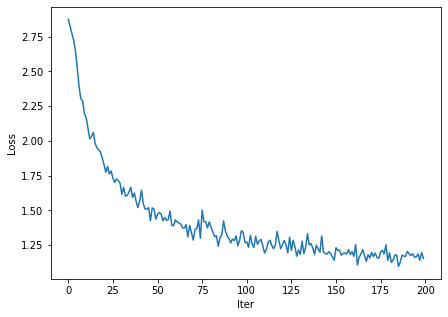

In [17]:
plt.figure(figsize=(7, 5))
plt.plot(all_losses)
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.show()

## Testing

To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). 

In [12]:
def evaluate(line_tensor):
    """
    Evaluate the RNN on a single line.
    """
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

In [13]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output, all_categories)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

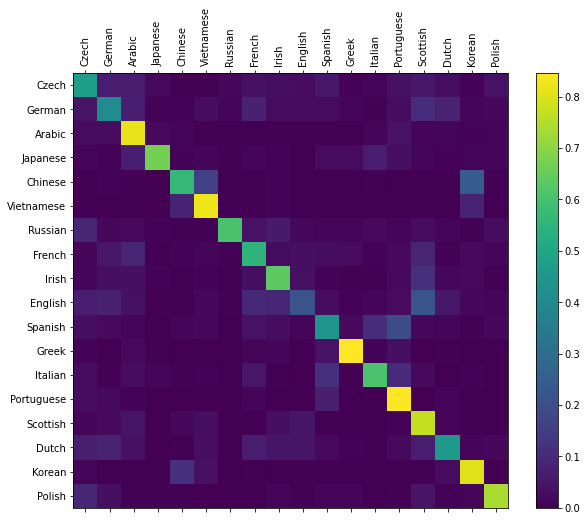

In [14]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticks(range(n_categories))
ax.set_xticklabels(all_categories, rotation=90)
ax.set_yticks(range(n_categories))
ax.set_yticklabels(all_categories)

plt.show()

In [15]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories (N = output size = n_categories)
        topv, topi = output.topk(n_predictions, 1, largest=True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [16]:
predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Huay')


> Dovesky
(-0.72) Czech
(-1.38) Russian
(-2.21) English

> Jackson
(-0.10) Scottish
(-3.33) English
(-3.87) German

> Satoshi
(-1.26) Arabic
(-1.52) Japanese
(-1.66) Polish

> Huay
(-0.75) Arabic
(-1.72) Scottish
(-2.01) Vietnamese
